# Policy Gradient Methods (Minigrid-gym)

 In this notebook you will learn how to:

 * Use open source RL environments
 * Set up the training pipelines for RL
 * Testing different environments and reward engineering
 * Implementing Policy Gradient method and its variation with a baseline function

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

## 1. Set up the environment
    For 

### Rendering images from the environment
 To debug the progress of our RL loop we will need to render the state of the environment

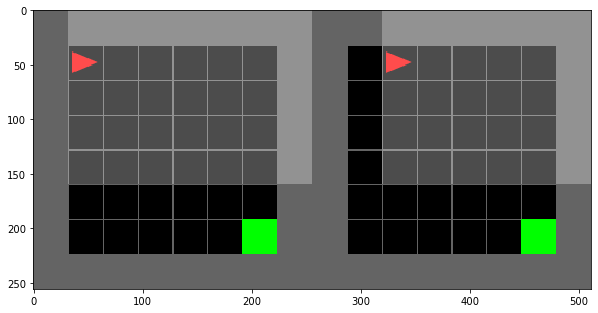

In [3]:
import gym
import gym_minigrid
import matplotlib.pyplot as plt

env = gym.make('MiniGrid-Empty-8x8-v0')
env.reset()
before_img = env.render('rgb_array')
action = env.actions.forward
obs, reward, done, info = env.step(action)
after_img = env.render('rgb_array')

plt.imshow(np.concatenate([before_img, after_img], 1))

### Play with your environment
 Create an instance of the environemnt type MiniGrid-8x8-v0

 Here are some info that you might find useful if you are new to the ```gym-minigrid```  
 
 * For each tile in a grid, the object is fully specified with the tuple (OBJECT, COLOR, STATE)  
  * List of OBJECT
    * unseen (0)
    * empty (1)
    * wall (2)
    * floor (3)
    * door (4)
    * key (5)
    * ball (6)
    * box (7)
    * goal (8)
    * lava (9)
    * agent (10)
  * List of COLOR
    * red (0)
    * green (1)
    * blue (2)
    * purple (3)
    * yellow (4)
    * grey (5)
  * List of STATE
    * open (0)
    * closed (1)
    * locked (2)  
    
 So for instance, if you see a tile encoded with the array [2,5,0], then it means the tile is a wall with the grey color  
   
   
 * The agent is colored with the red triangle pointing at the direction of its heading (UP, DOWN,RIGHT, LEFT)
  * List of ACTION
    * left (0)
    * right (1)
    * forward (2)
    * pick up (3)
    * drop (4)
    * toggle (5)
    * done (6)  
 * The agent has a partially observable view within the range of square of size ```self.agent_view_size``` (default: 7x7)
 * The agent can see through walls (default: False)  
   
 
 * Observation is a dict consists of 'image', 'direction', and 'mission'
  * The 'image' has an encoded info of each tile in 2D grid with ```column-major order``` (starting from top-left to down) 
 
   

Observation: {'image': array([[[2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0]],

       [[2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0]],

       [[2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0]],

       [[2, 5, 0],
        [2, 5, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]],

       [[2, 5, 0],
        [2, 5, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]],

       [[2, 5, 0],
        [2, 5, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]],

       [[2, 5, 0],
        [2, 5, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]]], dtype=uint8), 'direction': 0, 'm

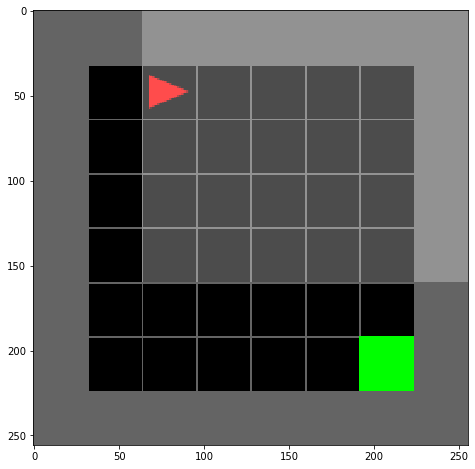

In [4]:
env = gym.make('MiniGrid-Empty-8x8-v0')

env.reset()

action = env.actions.forward

obs, reward, done, info = env.step(action)

img = env.render('rgb_array')

print('Observation:', obs)
print('Reward: ', reward)
print('Done: ', done)
print('Info: ', info)
print('Image shape: ', img.shape)
plt.imshow(img)
plt.show()

## Modifying an existing environment
 As you can see the environment's observation output also contains a rendered iamge as state representation (obs['image']). However, we want to train out deep RL agent from non-image state input (for faster convergence).  
 We will create a slightly altered version of the FullyObsWrapper from the repository who's observation function returns a flat vector representing the full grid

Observation: [ 1  0  0  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0
  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0
  1  0  0  1  0  0 10  0  0  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0
  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0
  1  0  0  1  0  0  1  0  0  8  1  0]
Reward:  0
Done:  False
Info:  {}
Image shape:  (256, 256, 3)


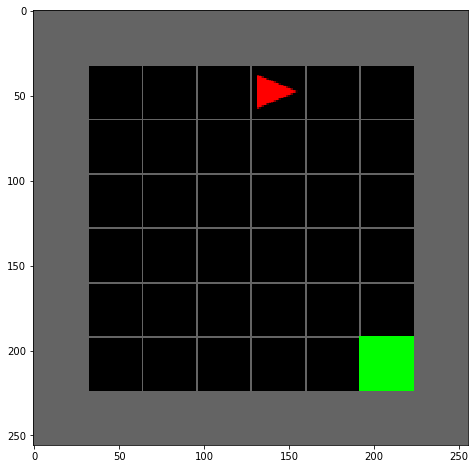

In [6]:
from gym import spaces
from gym_minigrid.minigrid import OBJECT_TO_IDX, COLOR_TO_IDX

max_env_steps = 50

class FlatObsWrapper(gym.core.ObservationWrapper):
    """Fully observable gridworld returnin a flat grid encoding"""
    
    def __init__(self, env):
        super().__init__(env)
        
        self.observation_space = spaces.Box(low=0, high=255, shape=((self.env.width-2) * (self.env.height-2) * 3,),
        dtype='uint8')
        self.unwrapped.max_steps = max_env_steps
        
    def observation(self, obs):
        # this method is called in the step() function to get the observation
        # it changes the observation from 'partially-observable' to 'fully-observable'
        env = self.unwrapped
        full_grid = env.grid.encode()
        full_grid[env.agent_pos[0]][env.agent_pos[1]] = np.array([OBJECT_TO_IDX['agent'],
                                                                 COLOR_TO_IDX['red'],
                                                                 env.agent_dir])
        full_grid = full_grid[1:-1, 1:-1]
        
        flattened_grid = full_grid.flatten()
        
        return flattened_grid
    
    def render(self, *args, **kwargs):
        """This removes the default visualization of the partially observable field of view"""
        kwargs['highlight'] = False
        return self.unwrapped.render(*args, **kwargs)
    
wrapped_env = FlatObsWrapper(env)

action = wrapped_env.actions.forward

wrapped_obs, reward, done, info = wrapped_env.step(action)

img = wrapped_env.render('rgb_array')

print('Observation:', wrapped_obs)
print('Reward: ', reward)
print('Done: ', done)
print('Info: ', info)
print('Image shape: ', img.shape)
plt.close()
plt.imshow(img)
plt.show()

### Plotting Videos
 As final step in the environment setup we provide a helper function to log videos of policy rollouts in the environment (see utils.py) Please check whether you can render the rollout of a random policy in the cell below

In [7]:
from gym.wrappers import Monitor
from utils import show_video

def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

def gen_wrapped_env(env_name):
    return wrap_env(FlatObsWrapper(gym.make(env_name)))

class RandPolicy:
    def __init__(self, action_space):
        self.action_space = action_space
        
    def act(self, *unsued_args):
        return self.action_space.sample(), None
    
# This function plots cideos of rollouts (episodes) of a given policy and environment

def log_policy_rollout(policy, env_name, pytorch_policy=False):
    env = gen_wrapped_env(env_name)
    
    observation = env.reset()
    
    done = False
    episode_reward = 0
    episode_length = 0
    
    while not done:
        if pytorch_policy:
            observation = torch.tensor(observation, dtype=torch.float32)
            action = policy.act(observation)[0].data.cpu().numpy()
        else:
            action = policy.act(observation)[0]
        observation, reward, done, info = env.step(action)
        
        episode_reward += reward
        episode_length += 1
        
    print('Total reward: ', episode_reward)
    print('Total length: ', episode_length)
    
    env.close()
    
    show_video()
    
test_env_name = 'MiniGrid-Empty-8x8-v0'
rand_policy = RandPolicy(FlatObsWrapper(gym.make(test_env_name)).action_space)
log_policy_rollout(rand_policy, test_env_name)

Total reward:  0
Total length:  50


## 2. Constructing the Rollout Buffer

 1. Collect rollouts of the current policy, store all trajectories
 2. Compute poilicy gradient using stored rollouts. Update the policy
 3. Repeat
 
 Can you tell the difference between ```Off-Policy RL``` and ```On-Policy RL```?

In [7]:
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler

class RolloutStorage():
    def __init__(self, rollout_size, obs_size):
        self.rollout_size = rollout_size
        self.obs_size = obs_size
        self.reset()
        
    def insert(self, step, done, action, log_prob, reward, obs):
        self.done[step].copy_(done)
        self.actions[step].copy_(action)
        self.log_probs[step].copy_(log_prob)
        self.rewards[step].copy_(reward)
        self.obs[step].copy_(obs)
        
    def reset(self):
        self.done = torch.zeros(self.rollout_size, 1)
        self.returns = torch.zeros(self.rollout_size + 1, 1, requires_grad=False)
        self.actions = torch.zeros(self.rollout_size, 1, dtype=torch.int64)
        self.log_probs = torch.zeros(self.rollout_size, 1)
        self.rewards = torch.zeros(self.rollout_size, 1)
        self.obs = torch.zeros(self.rollout_size, self.obs_size)
        
    def compute_returns(self, gamma):
        self.last_done = (self.done == 1).nonzero().max()
        self.returns[self.last_done + 1] = 0.
        
        for step in reversed(range(self.last_done + 1)):
            self.returns[step] = self.returns[step + 1] * gamma * (1 - self.done[step]) + self.rewards[step]
    
    def batch_sampler(self, batch_size, get_old_log_probs=False):
        sampler = BatchSampler(SubsetRandomSampler(range(self.last_done)),batch_size, drop_last=True)
        
        for indices in sampler:
            if get_old_log_probs:
                yield self.actions[indices], self.returns[indices], self.obs[indices], self.log_probs[indices]
            else:
                yield self.actions[indices], self.returns[indices], self.obs[indices]
        
        

## 3. Constructing the Policy Networks
 Now that we can store rollouts we need a policy to collect them. The policy is instantiated as a small neural network with simple fully-connected layers, the ActorNetwork.

 Start your implementation by constructing the network in ActorNetwork's constructor using the pytorch modules nn.Sequential and nn.Linear.

After the network is constructed we can complete the Policy class that uses the actor to implement the act(...) and update(...) functions. The gradient function for the policy update takes the following form:

∇J(θ)=Eπ[∇θlogπθ(a,s)Vt(s)]
 
 Here,  θ  are the parameters of the policy network  πθ  and  Vt(s)  is the observed future discounted reward from state  s  onwards which should be maximized.

 Entropy Loss: In order to encourage exploration, it is a common practice to add a weighted entropy-loss component that maximizes the entropy ( H ) of the policy distribution, so it takes diverse actions. So the joint objective becomes:

∇J(θ)=Eπ[∇θlogπθ(a,s)Vt(s)]+∇θH[πθ(a,s)]

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions.categorical import Categorical
from utils import count_model_params

class ActorNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_dim):
        super().__init__()
        self.num_actions = num_actions
        self.fc = nn.Sequential(nn.Linear(num_inputs, hidden_dim), nn.Tanh(), 
                               nn.Linear(hidden_dim, hidden_dim), nn.Tanh(),
                               nn.Linear(hidden_dim, num_actions))
        
    def forward(self, state):
        x = self.fc(state)
        return x
    
class Policy():
    def __init__(self, num_inputs, num_actions, hidden_dim, learning_rate, batch_size,
                 policy_epochs, entropy_coef=0.001):
        self.actor = ActorNetwork(num_inputs, num_actions, hidden_dim)
        self.optimizer = optim.Adam(self.actor.parameters(), lr = learning_rate)
        self.batch_size = batch_size
        self.policy_epochs = policy_epochs
        self.entropy_coef = entropy_coef
        
    def act(self, state):
        logits = self.actor.forward(state)
        dist = Categorical(logits=logits)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        return action, log_prob
    
    def evaluate_actions(self, state, action):
        logits = self.actor.forward(state)
        dist = Categorical(logits=logits)
        
        log_prob = dist.log_prob(action.squeeze(-1)).view(-1, 1)
        entropy = dist.entropy().view(-1, 1)
        return log_prob, entropy
    
    def update(self, rollouts):
        for epoch in range(self.policy_epochs):
            data = rollouts.batch_sampler(self.batch_size)
            
            for sample in data:
                actions_batch, returns_batch, obs_batch = sample
                
                log_probs_batch, entropy_batch = self.evaluate_actions(obs_batch, actions_batch)
                
                policy_loss = -torch.mean(log_probs_batch * returns_batch)
                entropy_loss = -torch.mean(entropy_batch)
                
                loss = policy_loss + self.entropy_coef * entropy_loss
                
                self.optimizer.zero_grad()
                loss.backward(retain_graph=False)
                self.optimizer.step()
    
    @property
    def num_params(self):
        return count_model_params(self.actor)


## 4. Setting up the Training Loop
        

In [9]:
from IPython.display import clear_output
from utils import AverageMeter, plot_learning_curve
import time

def train(env, rollouts, policy, params, seed=123):
    np.random.seed(seed)
    torch.manual_seed(seed)
    env.seed(seed)
    
    rollout_time, update_time = AverageMeter(), AverageMeter()
    rewards, success_rate = [], []
    
    print('Training model with {} parameters...'.format(policy.num_params))
    
    for j in range(params.num_updates):
        avg_eps_reward, avg_success_rate = AverageMeter(), AverageMeter()
        done = False
        prev_obs = env.reset()
        prev_obs = torch.tensor(prev_obs, dtype=torch.float32)
        eps_reward = 0.
        start_time = time.time()
        
        ## Collect rollouts
        for step in range(rollouts.rollout_size):
            if done:
                avg_eps_reward.update(eps_reward)
                if 'success' in info:
                    avg_success_rate.update(int(info['success']))
                    
                obs = env.reset()
                obs=  torch.tensor(obs, dtype=torch.float32)
                eps_reward = 0.
            else:
                obs = prev_obs
            # Take one step in env
            action, log_prob = policy.act(obs)
            obs, reward, done, info = env.step(action)
            
            # Insert the sample in the rollout buffer
            done = torch.tensor(done, dtype=torch.float32)
            reward = torch.tensor(reward, dtype=torch.float32)
            rollouts.insert(step, done, action, log_prob, reward, prev_obs)
            
            prev_obs = torch.tensor(obs, dtype=torch.float32)
            eps_reward += reward
            
        rollouts.compute_returns(params.discount)
        rollout_done_time = time.time()
        
        # Update with given rollout samples
        policy.update(rollouts)
        
        update_done_time = time.time()
        rollouts.reset()
        
        ## log metrics
        rewards.append(avg_eps_reward.avg)
        if avg_success_rate.count > 0:
            success_rate.append(avg_success_rate.avg)
        rollout_time.update(rollout_done_time - start_time)
        update_time.update(update_done_time - rollout_done_time)
        print('it {}: avgR: {:.3f} -- rollout_time: {:.3f}sec -- update_time: {:.3f}sec'.format(j, avg_eps_reward.avg, 
                                                                                                rollout_time.avg, 
                                                                                                update_time.avg))
        if j % params.plotting_iters == 0 and j != 0:
            plot_learning_curve(rewards, success_rate, params.num_updates)
            log_policy_rollout(policy, params.env_name, pytorch_policy=True)
    clear_output()   # this removes all training outputs to keep the notebook clean, DON'T REMOVE THIS LINE!
    return rewards, success_rate
        
        

**instantiate**: We provide a function to instantiate the environment, rollout buffer and policy class given their parameters

In [10]:
from utils import ParamDict
import copy

def instantiate(params_in, nonwrapped_env=None):
    params = copy.deepcopy(params_in)

    if nonwrapped_env is None:
        nonwrapped_env = gym.make(params.env_name)

    env = None
    env = FlatObsWrapper(nonwrapped_env)    
    obs_size = env.observation_space.shape[0]
    num_actions = env.action_space.n

    rollouts = RolloutStorage(params.rollout_size, obs_size)
    policy_class = params.policy_params.pop('policy_class')
    
    policy = policy_class(obs_size, num_actions, **params.policy_params)
    return env, rollouts, policy

### Setting hyperparameters

In [11]:
# hyperparameters
policy_params = ParamDict(
    policy_class = Policy,    # Policy class to use (replaced later)     
    hidden_dim = 32,          # dimension of the hidden state in actor network
    learning_rate = 1e-3,     # learning rate of policy update
    batch_size = 1024,        # batch size for policy update
    policy_epochs = 4,        # number of epochs per policy update
    entropy_coef = 0.001,     # hyperparameter to vary the contribution of entropy loss
)
params = ParamDict(
    policy_params = policy_params,
    rollout_size = 2050,      # number of collected rollout steps per policy update
    num_updates = 50,         # number of training policy iterations
    discount = 0.99,          # discount factor
    plotting_iters = 10,      # interval for logging graphs and policy rollouts
    env_name = 'MiniGrid-Empty-5x5-v0',  # we are using a tiny environment here for testing
)

### Run the training

In [12]:
env, rollouts, policy = instantiate(params)
rewards, success_rate = train(env, rollouts, policy, params)
print("Training completed!")

Training completed!


### Evaluation

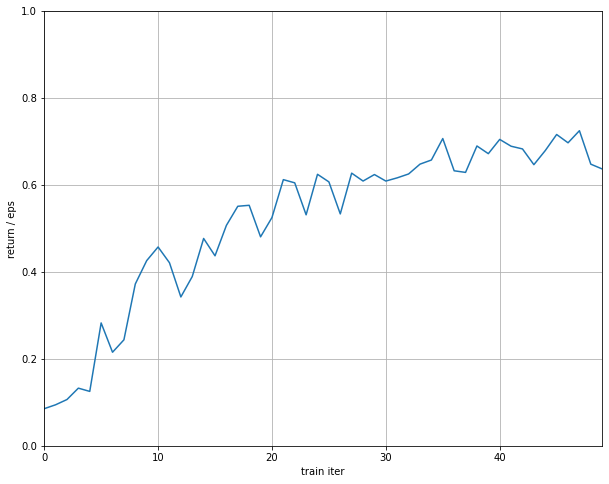

Total reward:  0.766
Total length:  13


Total reward:  0
Total length:  50


Total reward:  0.712
Total length:  16


In [14]:
# final reward + policy plotting for easier evaluation
plot_learning_curve(rewards, success_rate, params.num_updates)
for _ in range(3):
    log_policy_rollout(policy, params.env_name, pytorch_policy=True)

## Testing on more complex environments

In [15]:
# hyperparameters
policy_params = ParamDict(
    policy_class = Policy,    # Policy class to use (replaced later)
    hidden_dim = 32,          # dimension of the hidden state in actor network
    learning_rate = 1e-3,     # learning rate of policy update
    batch_size = 1024,        # batch size for policy update
    policy_epochs = 4,        # number of epochs per policy update
    entropy_coef = 0.001,     # hyperparameter to vary the contribution of entropy loss
)
params = ParamDict(
    policy_params = policy_params,
    rollout_size = 2050,      # number of collected rollout steps per policy update
    num_updates = 50,         # number of training policy iterations
    discount = 0.99,          # discount factor
    plotting_iters = 10,      # interval for logging graphs and policy rollouts
    env_name = 'MiniGrid-Empty-8x8-v0',  # we are using a tiny environment here for testing
)


env, rollouts, policy = instantiate(params)
rewards, success_rate = train(env, rollouts, policy, params)
print("Training completed!")

Training completed!


**Evaluation - bigger gridworld**

    The average episode reward should also reach ~0.5 after ~60 iterations. If you can't achieve this result then try rerunning your training, randomness can play a big role in the beginninig of training

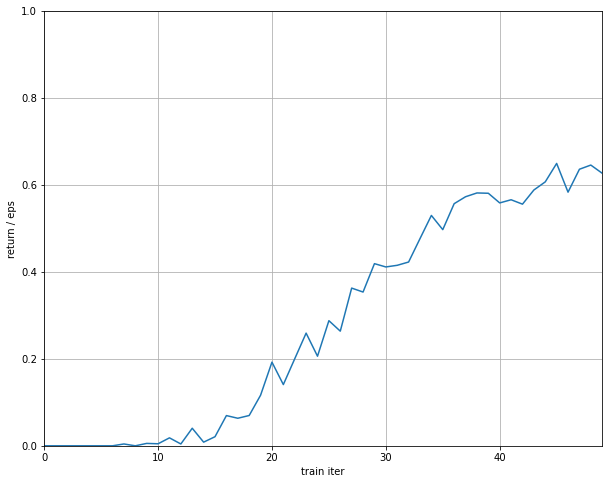

Total reward:  0.748
Total length:  14


Total reward:  0.802
Total length:  11


Total reward:  0
Total length:  50


In [16]:
plot_learning_curve(rewards, success_rate, params.num_updates)
for _ in range(3):
    log_policy_rollout(policy, params.env_name, pytorch_policy=True)

**Question**
1. Please compare the trainig curves for the two grids of different size
2. Explain why the bigger maze tends to learn slower in the beginning of training

## 6. Exploring the effect of Reward Design

    Rewards are central to RL as they provide guidance to the policy about the desired agent behavior. There are many different ways to specify rewards and each of them has their own trade-offs: from 'easy to specify but hard to learn' all the way to 'challenging to specify but easy learning'

In [18]:
n_seeds = 3

All training runs completed!


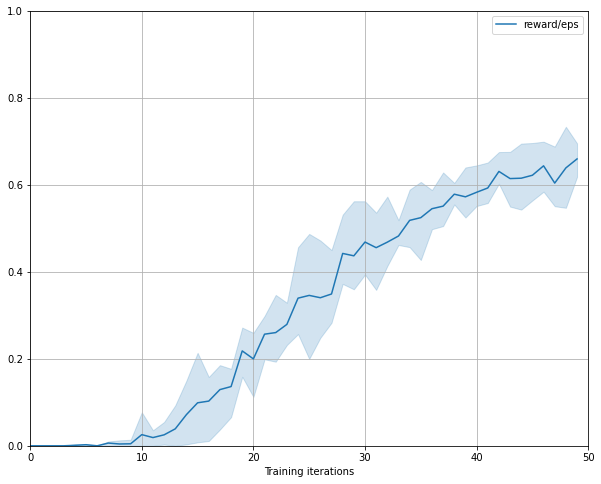

In [20]:
rewards, success_rates = [], []
for i in range(n_seeds):
    print('Start training run {}!'.format(i))
    env, rollouts, policy = instantiate(params)
    r, sr = train(env, rollouts, policy, params, seed=i)
    rewards.append(r)
    success_rates.append(sr)
print('All training runs completed!')
plot_learning_curve(rewards, success_rate, params.num_updates, plot_std=True)

**Sparse Reward Environment**
    We explore sparse rewards in our test environment by providing a reward of one when the agent reaches the target (minus a small penalty depending on how long it took the agent to get there) and zero reward otherwise. Run the training code on this new environment and see how the algorithm behaves. Since these environments are harder, we train it for longer (see num_updates)

In [21]:
from minigrid_utils import DeterministicCrossingEnv
import warnings

def gen_wrapped_env(env_name):
    if env_name is 'det_sparse':
        warnings.filterwarnings('ignore')
        return wrap_env(FlatObsWrapper(DeterministicCrossingEnv()))
    return wrap_env(FlatObsWrapper(gym.make(env_name)))

In [22]:
# hyperparameters
policy_params = ParamDict(
    policy_class = Policy,    # Policy class to use (replaced later)
    hidden_dim = 32,          # dimension of the hidden state in actor network
    learning_rate = 1e-3,     # learning rate of policy update
    batch_size = 1024,        # batch size for policy update
    policy_epochs = 4,        # number of epochs per policy update
    entropy_coef = 0.001,     # hyperparameter to vary the contribution of entropy loss
)
params = ParamDict(
    policy_params = policy_params,
    rollout_size = 2050,      # number of collected rollout steps per policy update
    num_updates = 200,        # number of training policy iterations
    discount = 0.99,          # discount factor
    plotting_iters = 10,      # interval for logging graphs and policy rollouts
    env_name = 'det_sparse',  # we are using a tiny environment here for testing
)

rewards_sparse, success_rates_sparse = [], []
for i in range(n_seeds):
    print("Start training run {}!".format(i))
    env, rollouts, policy = instantiate(params, nonwrapped_env=DeterministicCrossingEnv())
    r, sr = train(env, rollouts, policy, params, seed=i)
    rewards_sparse.append(r); success_rates_sparse.append(sr)
print('All training runs completed!')

All training runs completed!


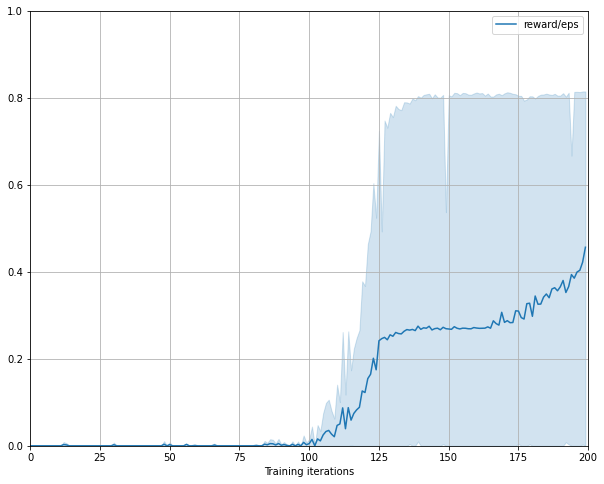

Total reward:  0.82
Total length:  10


Total reward:  0.802
Total length:  11


Total reward:  0.82
Total length:  10


In [23]:
plot_learning_curve(rewards_sparse, success_rates_sparse, params.num_updates, plot_std=True)
for _ in range(3):
    log_policy_rollout(policy, params.env_name, pytorch_policy=True)

**Densify Rewards**

    As you have seen in the previous examples, this makes it very challenging to effectively learn a good policy. In practice, we therefore usually resort to constructing a more dense reward that gives the policy more guidance during learning. How to make the reward more dense is highly problem-dependent

In [27]:
from minigrid_utils import (DeterministicCrossingEnv, DetHardEuclidCrossingEnv, DetHardSubgoalCrossingEnv)
import warnings

def gen_wrapped_env(env_name):
    if env_name is 'det_sparse':
        warnings.filterwarnings("ignore")   # suppress warning when plotting
        return wrap_env(FlatObsWrapper(DetSparseCrossingEnv()))
    if env_name is 'det_subgoal':
        warnings.filterwarnings("ignore")   # suppress warning when plotting
        return wrap_env(FlatObsWrapper(DetHardSubgoalCrossingEnv()))
    elif env_name is 'det_euclid':
        warnings.filterwarnings("ignore")   # suppress warning when plotting
        return wrap_env(FlatObsWrapper(DetHardEuclidCrossingEnv()))
    return wrap_env(FlatObsWrapper(gym.make(env_name)))

**Subgoal Reward**

    We will first try a hybrid solution between a sparse setup where the agent receives rewards only when the goal is reached and a truly dense setup where the agent receives reward in every step. Concretely, we will add one more subgoal to the environment to encourage the agent to reach the bottleneck state that passes through the wall. Upon reaching the subgoal the agent will receive a positive reward, encouraging it to reach the bottleneck more often. Laying out such a "path of breadcrumbs" is a standard practice in RL and we will explore whether our agent can benefit from it.

In [28]:
# hyperparameters
policy_params = ParamDict(
    policy_class = Policy,    # Policy class to use (replaced later)
    hidden_dim = 32,          # dimension of the hidden state in actor network
    learning_rate = 1e-3,     # learning rate of policy update
    batch_size = 1024,        # batch size for policy update
    policy_epochs = 4,        # number of epochs per policy update
    entropy_coef = 0.001,     # hyperparameter to vary the contribution of entropy loss
)
params = ParamDict(
    policy_params = policy_params,
    rollout_size = 2050,      # number of collected rollout steps per policy update
    num_updates = 200,        # number of training policy iterations
    discount = 0.99,          # discount factor
    plotting_iters = 10,      # interval for logging graphs and policy rollouts
    env_name = 'det_subgoal',  # we are using a tiny environment here for testing
)

rewards_subgoal, success_rates_subgoal = [], []
for i in range(n_seeds):
    print("Start training run {}!".format(i))
    env, rollouts, policy = instantiate(params, nonwrapped_env=DetHardSubgoalCrossingEnv())
    r, sr = train(env, rollouts, policy, params, seed=i)
    rewards_subgoal.append(r); success_rates_subgoal.append(sr)
print('All training runs completed!')

All training runs completed!


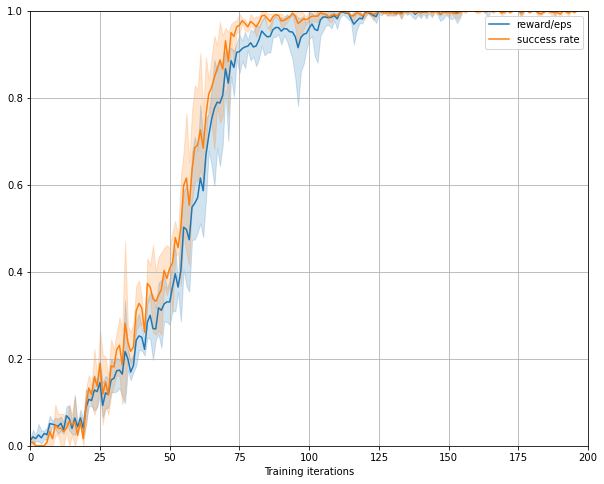

Total reward:  1.02
Total length:  10


Total reward:  1.02
Total length:  10


Total reward:  1.02
Total length:  10


In [29]:
plot_learning_curve(rewards_subgoal, success_rates_subgoal, params.num_updates, plot_std=True)
for _ in range(3):
    log_policy_rollout(policy, params.env_name, pytorch_policy=True)

## Dense Reward (distance-based)

    While adding subgoals provided some guidance signal to the agent, we will try to further "densify" the reward formulation. Concretely, we will explore a rather straightforward way to define a dense reward: we will use the euclidean distance  d  between the current agent position to the goal to define a reward.

At this point one could be tempted to simply use the complement  1−d  as reward such that maximizing it would lead the agent to minimize the distance to the goal. This is a good example for why specifying dense rewards is hard! If we were to choose this simple reward formulation the agent would actually be encouraged to move next to the goal, but then wait next to the goal until right before the timeout of the episode is reached as terminating early is worse than receiving a long stream of high rewards while waiting next to the goal.

To prevent such "lazyness", we instead look at the differnce of the current distance to the goal and the previous step's distance. If this difference is negative, i.e. if we moved closer to the goal with the last action, we reward the agent. If we moved away from the goal we instead return a negative reward to the agent. If we distance does not change, i.e. if the agent stays in place, we do not provide any reward. In this way the agent is encouraged to choose actions that bring it closer to the goal while there is no benefit to waiting next to the goal (the discount factor <1 ensures that waiting is actually a bad choice).

In [30]:
# hyperparameters
policy_params = ParamDict(
    policy_class = Policy,    # Policy class to use (replaced later)
    hidden_dim = 32,          # dimension of the hidden state in actor network
    learning_rate = 1e-3,     # learning rate of policy update
    batch_size = 1024,        # batch size for policy update
    policy_epochs = 4,        # number of epochs per policy update
    entropy_coef = 0.001,     # hyperparameter to vary the contribution of entropy loss
)
params = ParamDict(
    policy_params = policy_params,
    rollout_size = 2050,      # number of collected rollout steps per policy update
    num_updates = 200,        # number of training policy iterations
    discount = 0.99,          # discount factor
    plotting_iters = 10,      # interval for logging graphs and policy rollouts
    env_name = 'det_euclid',  # we are using a tiny environment here for testing
)

rewards_dense, success_rates_dense = [], []
for i in range(n_seeds):
    print("Start training run {}!".format(i))
    env, rollouts, policy = instantiate(params, nonwrapped_env=DetHardEuclidCrossingEnv())
    r, sr = train(env, rollouts, policy, params, seed=i)
    rewards_dense.append(r); success_rates_dense.append(sr)
print('All training runs completed!')

All training runs completed!


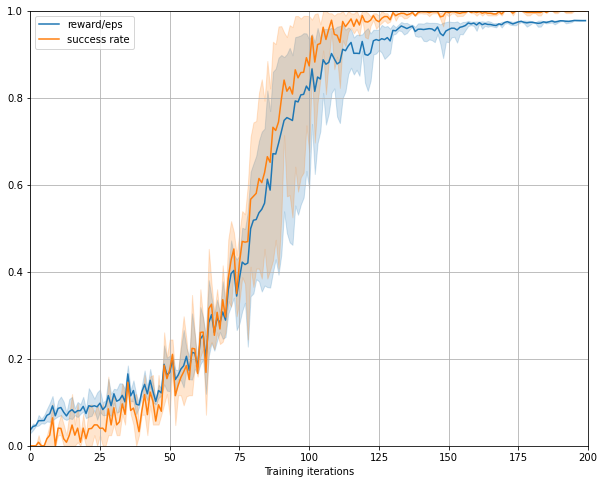

Total reward:  0.98
Total length:  10


Total reward:  0.98
Total length:  10


Total reward:  0.98
Total length:  10


In [31]:
plot_learning_curve(rewards_dense, success_rates_dense, params.num_updates, plot_std=True)
for _ in range(3):
    log_policy_rollout(policy, params.env_name, pytorch_policy=True)

## Optimal Dense Reward
    In the previous example we saw that adding dense rewards can help speeding up training, however there were some degeneracies which discouraged the agent from learning the optimal policy. This process is typical when tackling a new task with RL: one tries sparse rewards and then keeps increasing the density of the reward until the agent is able to learn the desired behavior. Along the way the agent will discover various ways in which to exploit the different reward choices (remember the "lazy" behavior described above), requiring tedious changes to the reward design. This process, known as "reward engineering" is a big pain when developing RL solutions.

In the following we will sidestep this process. In our simple obstacle maze environment it is relatively straightforward to define a reward that is likely very close to "optimal". We will alter the dense reward from the previous section to use the shortest-path distance between the agent and the goal. We do this by computing the manhattan distance while taking the walls into account.

In [32]:
from minigrid_utils import DetHardOptRewardCrossingEnv

class CustomEnv(DetHardOptRewardCrossingEnv):
    def manhattan_distance(self, x, y):
        ############################## TODO: YOUR CODE BELOW ###############################
        ### Compute the manhattan distance between two coordinates x and y                ###
        ### x and y are 2D numpy arrays                                                  ###
        ####################################################################################
        distance = abs(x[0]-y[0]) + abs(x[1]-y[1])
        ################################# END OF YOUR CODE #################################
        return distance
    
def gen_wrapped_env(env_name):
    if env_name is 'det_sparse':
        warnings.filterwarnings("ignore")   # suppress warning when plotting
        return wrap_env(FlatObsWrapper(DetSparseCrossingEnv()))
    elif env_name is 'det_subgoal':
        warnings.filterwarnings("ignore")   # suppress warning when plotting
        return wrap_env(FlatObsWrapper(DetHardSubgoalCrossingEnv()))
    elif env_name is 'det_euclid':
        warnings.filterwarnings("ignore")   # suppress warning when plotting
        return wrap_env(FlatObsWrapper(DetHardEuclidCrossingEnv()))
    elif env_name is 'custom_env':
        warnings.filterwarnings("ignore")   # suppress warning when plotting
        return wrap_env(FlatObsWrapper(CustomEnv()))
    return wrap_env(FlatObsWrapper(gym.make(env_name)))

In [33]:
# hyperparameters
policy_params = ParamDict(
    policy_class = Policy,    # Policy class to use (replaced later)
    hidden_dim = 32,          # dimension of the hidden state in actor network
    learning_rate = 1e-3,     # learning rate of policy update
    batch_size = 1024,        # batch size for policy update
    policy_epochs = 4,        # number of epochs per policy update
    entropy_coef = 0.001,     # hyperparameter to vary the contribution of entropy loss
)
params = ParamDict(
    policy_params = policy_params,
    rollout_size = 2050,      # number of collected rollout steps per policy update
    num_updates = 200,        # number of training policy iterations
    discount = 0.99,          # discount factor
    plotting_iters = 10,      # interval for logging graphs and policy rollouts
    env_name = 'custom_env',  # we are using a tiny environment here for testing
)

rewards_custom, success_rates_custom = [], []
for i in range(n_seeds):
    print("Start training run {}!".format(i))
    env, rollouts, policy = instantiate(params, nonwrapped_env=CustomEnv())
    r, sr = train(env, rollouts, policy, params, seed=i)
    rewards_custom.append(r); success_rates_custom.append(sr)
print('All training runs completed!')

All training runs completed!


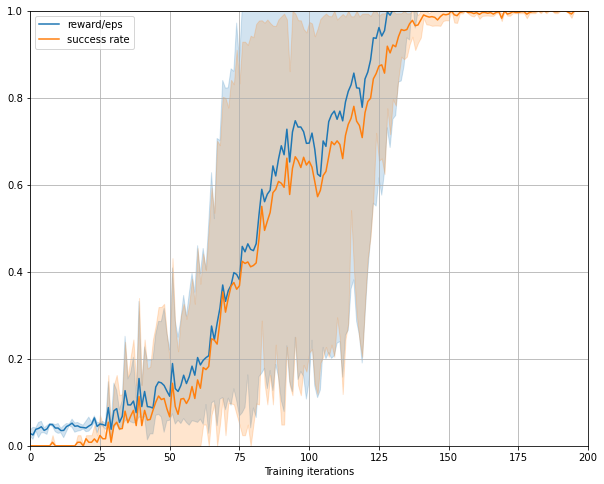

Total reward:  1.17
Total length:  10


Total reward:  1.098
Total length:  14


Total reward:  1.17
Total length:  10


In [34]:
plot_learning_curve(rewards_custom, success_rates_custom, params.num_updates, plot_std=True)
for _ in range(3):
    log_policy_rollout(policy, params.env_name, pytorch_policy=True)

## Compile Reward Design Results


In order to make comparison across reward design experiments easier, please run the following code block to make a combined code block.


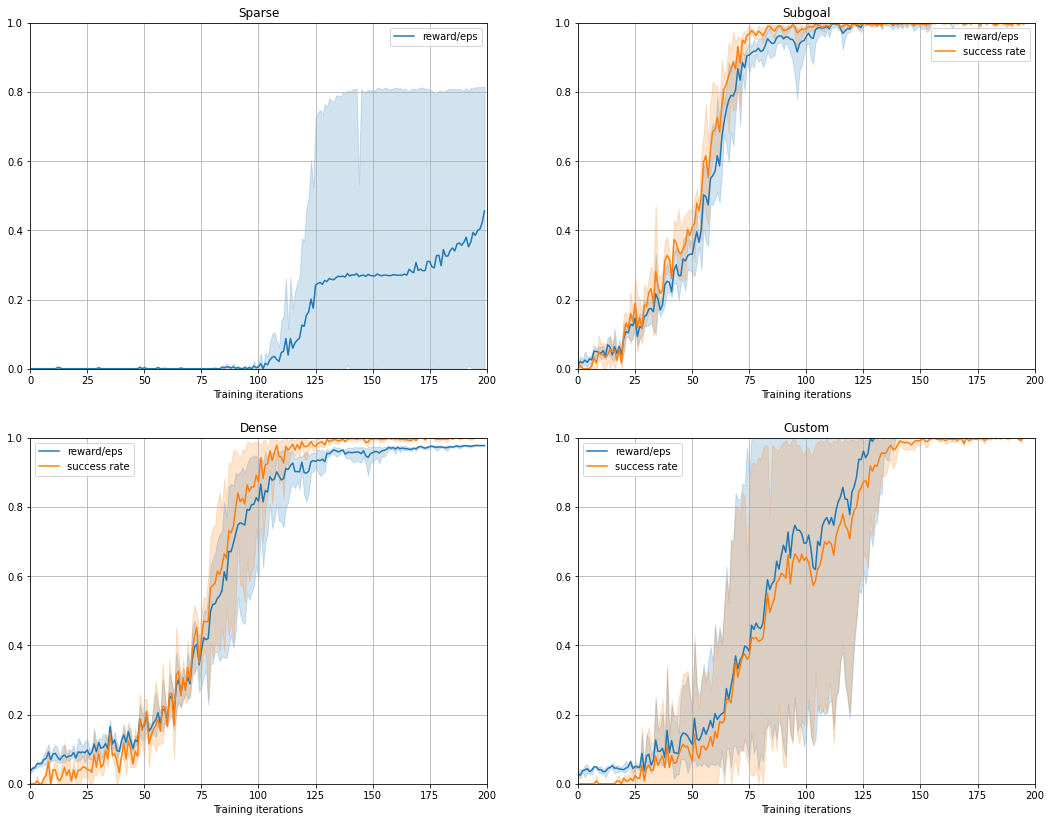

In [35]:
from utils import plot_grid_std_learning_curves
plots = {
'Sparse': (rewards_sparse, success_rates_sparse),
'Subgoal': (rewards_subgoal, success_rates_subgoal),
'Dense': (rewards_dense, success_rates_dense),
'Custom': (rewards_custom, success_rates_custom)}

plt.rcParams['figure.figsize'] = (18.0, 14.0) # set default size of plots
plot_grid_std_learning_curves(plots, params.num_updates)
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots

**Questions**

Give two-line answers to the following questions:

(1) Compare the performance of the different dense reward formulations. Which formulation is better and why do you think so? (3 pts)

Ans:

(2) What are some real world applications where it is easy to design dense rewards, and what are some where it is not possible? (3 pts)

Ans:

(3) Based on the insights gain from experiments above, what is a good strategy to adopt in scenarios where good dense reward is not available? Why do you think so? (3 pts)

Ans:

## 7. Add a Baseline Network

Since REINFORCE relies on sampling-based gradient estimates to update the policy, the gradients can be very noisy, which can make the training unstable and slow. There are many ways which attempt to reduce the variance in learning, and one such way is to use a baseline.

The key idea of a baseline is that if we add or subtract a term  b(st)  which is independent of action to the estimated returns  Vt , then the expected value still remains the same:

∇J(θ)=Eπ[∇θlogπθ(a,s)Vt(s)]=Eπ[∇θlogπθ(a,s)[Vt(s)−bt(s)]]
 
Hence, this keeps the gradient estimates unbiased (that is close to real gradients), and can help in reducing the variance if it is able to reduce the magnitude of gradients. Reduced variance can potentially lead to more stable training.

A good baseline to use is the value function of a state  bt(s)=vt(s) , which can be trained along with the policy. The value function acts like a critic to the actor (policy network), where the critic's objective is to estimate correct expected returns  Vt(s)  and actor's objective is the policy gradient augmented by critic's predictions.

The term  Vt(s)−vt(s)  is called the advantage, and it measures how well the policy is expected to do (estimated by expected rewards) as compared to the average value of a state (estimated by value function).

In [36]:
class CriticNetwork(nn.Module):
    def __init__(self, num_inputs, hidden_dim):
        super().__init__()

        ############################## TODO: YOUR CODE BELOW ###############################
        ### 1. Build the Actor network as a torch.nn.Sequential module                   ###
        ###    with the following layers:                                                ###
        ###        (1) a Linear layer mapping from input dimension to hidden dimension   ###
        ###        (2) a Tanh non-linearity                                              ###
        ###        (3) a Linear layer mapping from hidden dimension to hidden dimension  ###
        ###        (4) a Tanh non-linearity                                              ###
        ###        (5) a Linear layer mapping from hidden dimension to appropriate       ###
        ###            dimension                                                         ###
        ### HINT: We do not need an activation on the output, because the actor is       ###
        ###       predicting a value, which can be any real number                       ###
        ####################################################################################
        self.fc = nn.Sequential(nn.Linear(num_inputs, hidden_dim), nn.Tanh(),
                               nn.Linear(hidden_dim, hidden_dim), nn.Tanh(),
                               nn.Linear(hidden_dim, 1))
        ################################# END OF YOUR CODE #################################

    def forward(self, state):
        x = self.fc(state)
        return x


class ACPolicy(Policy):
    def __init__(self, num_inputs, num_actions, hidden_dim, learning_rate, batch_size, policy_epochs,
                 entropy_coef=0.001, critic_coef=0.5):
        super().__init__(num_inputs, num_actions, hidden_dim, learning_rate, batch_size, policy_epochs, entropy_coef)

        self.critic = CriticNetwork(num_inputs, hidden_dim)
        
        ############################## TODO: YOUR CODE BELOW ###############################
        ### Create a common optimizer for actor and critic with the given learning rate  ###
        ### (requires 1-line of code)                                                    ###
        ####################################################################################
        self.optimizer = optim.Adam([{'params': self.actor.parameters()},
                                     {'params': self.critic.parameters()}], lr=learning_rate)
        ################################# END OF YOUR CODE #################################

        self.critic_coef = critic_coef
        
    def update(self, rollouts):    
        for epoch in range(self.policy_epochs):
            data = rollouts.batch_sampler(self.batch_size)
            
            for sample in data:
                actions_batch, returns_batch, obs_batch = sample
                log_probs_batch, entropy_batch = self.evaluate_actions(obs_batch, actions_batch)

                value_batch = self.critic(obs_batch)
                advantage = returns_batch - value_batch.detach()

                ############################## TODO: YOUR CODE BELOW ###############################
                ### 1. Compute the mean loss for the policy update using action log-             ###
                ###     probabilities and advantages.                                            ###
                ### 2. Compute the mean entropy for the policy update                            ###
                ### 3. Compute the critic loss as MSE loss between estimated value and expected  ###
                ###     returns.                                                                 ###
                ###    *HINT*: Carefully select the signs of each of the losses .                ###
                ####################################################################################
                policy_loss = -torch.mean(log_probs_batch * advantage)
                entropy_loss = -torch.mean(entropy_batch)
                critic_loss = torch.mean(advantage * advantage)
                ################################# END OF YOUR CODE #################################
                
                loss = policy_loss + \
                        self.critic_coef * critic_loss + \
                        self.entropy_coef * entropy_loss

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
    @property
    def num_params(self):
        return super().num_params + count_model_params(self.critic)

In [37]:
# hyperparameters
policy_params = ParamDict(
    policy_class = ACPolicy,  # Policy class to use (replaced later)
    hidden_dim = 32,          # dimension of the hidden state in actor network
    learning_rate = 1e-3,     # learning rate of policy update
    batch_size = 1024,        # batch size for policy update
    policy_epochs = 4,        # number of epochs per policy update
    entropy_coef = 0.001,     # hyperparameter to vary the contribution of entropy loss
    critic_coef = 0.5         # Coefficient of critic loss when weighted against actor loss
)
params = ParamDict(
    policy_params = policy_params,
    rollout_size = 2050,      # number of collected rollout steps per policy update
    num_updates = 200,        # number of training policy iterations
    discount = 0.99,          # discount factor
    plotting_iters = 10,      # interval for logging graphs and policy rollouts
    env_name = 'custom_env',  # we are using a tiny environment here for testing
)

rewards, success_rates = [], []
for i in range(n_seeds):
    print("Start training run {}!".format(i))
    env, rollouts, policy = instantiate(params, nonwrapped_env=CustomEnv())
    r, sr = train(env, rollouts, policy, params, seed=i)
    rewards.append(r); success_rates.append(sr)
print('All training runs completed!')

All training runs completed!


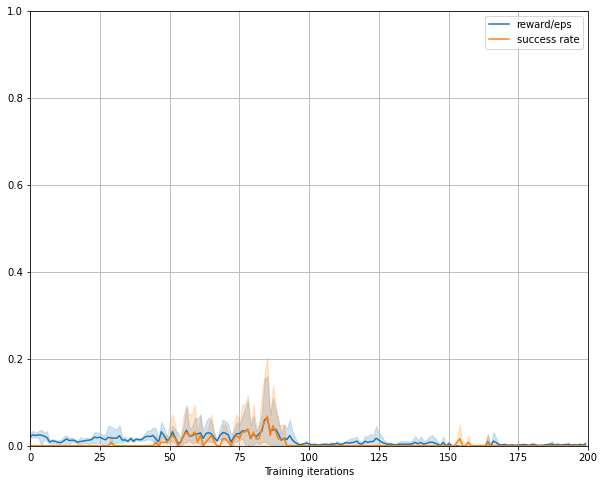

Total reward:  0.0
Total length:  50


Total reward:  0.0
Total length:  50


Total reward:  0.0
Total length:  50


In [38]:
plot_learning_curve(rewards, success_rates, params.num_updates, plot_std=True)
for _ in range(3):
    log_policy_rollout(policy, params.env_name, pytorch_policy=True)

Questions (4 pts)
(1) How does the actor critic algorithm perform as compared to vanilla policy gradients?

Ans:

(2) Can we make reliable comparisons with these experiments and plots, and why do you think so?

Ans:

## 8. Proximal Policy Optimization (PPO)

PPO is an actor-critic algorithm which constrains the gradient updates to a policy by modifying the training objective with a clipped surrogate objective. This essentially results in a more stable optimization procedure, and hence leads to better sample efficiency and fast computation time, as compared to vanilla policy gradient methods. It is very easy to implement, and here you are supposed to modify the update function of Actor Critic Policy to incorporate these surrogate losses.

ratio=πnew(a)πold(a)=elogπnew(a)−logπold(a)
 
Lsurrogate1=ratio∗Advantage
 
Lsurrogate2=clip(ratio,1−c,1+c)∗Advantage
 
Lpolicy=−min(Lsurrogate1,Lsurrogate2)

In [ ]:
class PPO(ACPolicy):       
    def update(self, rollouts): 
        self.clip_param = 0.2
        for epoch in range(self.policy_epochs):
            data = rollouts.batch_sampler(self.batch_size, get_old_log_probs=True)
            
            for sample in data:
                actions_batch, returns_batch, obs_batch, old_log_probs_batch = sample
                log_probs_batch, entropy_batch = self.evaluate_actions(obs_batch, actions_batch)
                
                value_batch = self.critic(obs_batch)
                
                advantage = returns_batch - value_batch.detach()
                old_log_probs_batch = old_log_probs_batch.detach()

                ############################## TODO: YOUR CODE BELOW ###############################
                ### Compute the following terms by following the equations given above           ###
                ### Useful functions: torch.exp(...), torch.clamp(...)
                ### Note: self.clip_param is the c in the above equations                        ###
                ### Compute the following terms by following the equations given above           ###
                ####################################################################################
                ratio = None
                surr1 = None
                surr2 = None

                policy_loss = None
                entropy_loss = None
                critic_loss = None
                ################################# END OF YOUR CODE #################################

                loss = policy_loss + \
                        self.critic_coef * critic_loss + \
                        self.entropy_coef * entropy_loss

                self.optimizer.zero_grad()
                loss.backward(retain_graph=False)
                self.optimizer.step()

In [ ]:
# hyperparameters
policy_params = ParamDict(
    policy_class = PPO,  # Policy class to use (replaced later)
    hidden_dim = 32,          # dimension of the hidden state in actor network
    learning_rate = 1e-3,     # learning rate of policy update
    batch_size = 1024,        # batch size for policy update
    policy_epochs = 4,        # number of epochs per policy update
    entropy_coef = 0.001,     # hyperparameter to vary the contribution of entropy loss
    critic_coef = 0.5         # Coefficient of critic loss when weighted against actor loss
)
params = ParamDict(
    policy_params = policy_params,
    rollout_size = 2050,      # number of collected rollout steps per policy update
    num_updates = 200,        # number of training policy iterations
    discount = 0.99,          # discount factor
    plotting_iters = 10,      # interval for logging graphs and policy rollouts
    env_name = 'custom_env',  # we are using a tiny environment here for testing
)

rewards, success_rates = [], []
for i in range(n_seeds):
    print("Start training run {}!".format(i))
    env, rollouts, policy = instantiate(params, nonwrapped_env=CustomEnv())
    r, sr = train(env, rollouts, policy, params, seed=i)
    rewards.append(r); success_rates.append(sr)
print('All training runs completed!')

In [ ]:
plot_learning_curve(rewards, success_rates, params.num_updates, plot_std=True)
for _ in range(3):
    log_policy_rollout(policy, params.env_name, pytorch_policy=True)